This is a binary classification task based on Santander Customer Satisfaction Challenge on Kaggle. (https://www.kaggle.com/c/santander-customer-satisfaction)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

In [2]:
# Read in data
data = pd.read_csv('train.csv')
data.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [3]:
data.shape

(76020, 371)

### EDA

In [4]:
# Helper function for identifying missing values in each feature.
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [5]:
missing_data(data)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64


There is no missing values in the dataset.

In [6]:
# Analyse the distribution of the data
data.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


- Standard deviation is relatively large for all features.
- Mean values are distributed over a large range, with var3 being the weirdest.

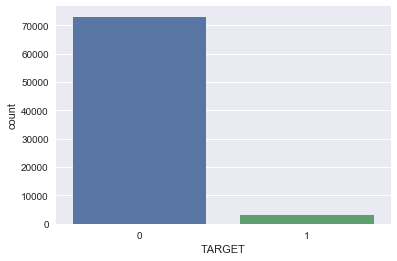

In [7]:
# Analyse label distribution to see if it's an imbalanced classification problem
sns.countplot(data['TARGET'])

In [8]:
print("There are {}% target values with 1".format(100 * data["TARGET"].value_counts(normalize=True)[1]))

There are 3.9568534596158904% target values with 1


In [9]:
# Helper function for analysing feature distribution and relationship between each feature 
# and the label by visualisation.
def plot_feature_distribution(data, features):
    plt.figure()
    if len(features)%10 == 0:
        fig, ax = plt.subplots(int(len(features)/10), 10, figsize=(18,22))
    else:
        fig, ax = plt.subplots(int(len(features)/10)+1, 10, figsize=(18,22))
    sns.set_style('whitegrid')
    data_0 = data.loc[data['TARGET']==0]
    data_1 = data.loc[data['TARGET']==1]

    for i,feature in enumerate(features):
        if len(features)%10 == 0:
            plt.subplot(int(len(features)/10), 10, i+1)
        else:
            plt.subplot(int(len(features)/10)+1, 10, i+1)
        sns.kdeplot(data_0[feature], bw=0.5,label=0, color='r')
        sns.kdeplot(data_1[feature], bw=0.5,label=1, color='b')
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show()

In [10]:
features = list(data.columns)
features.remove('ID')
features.remove('TARGET')

<Figure size 432x288 with 0 Axes>

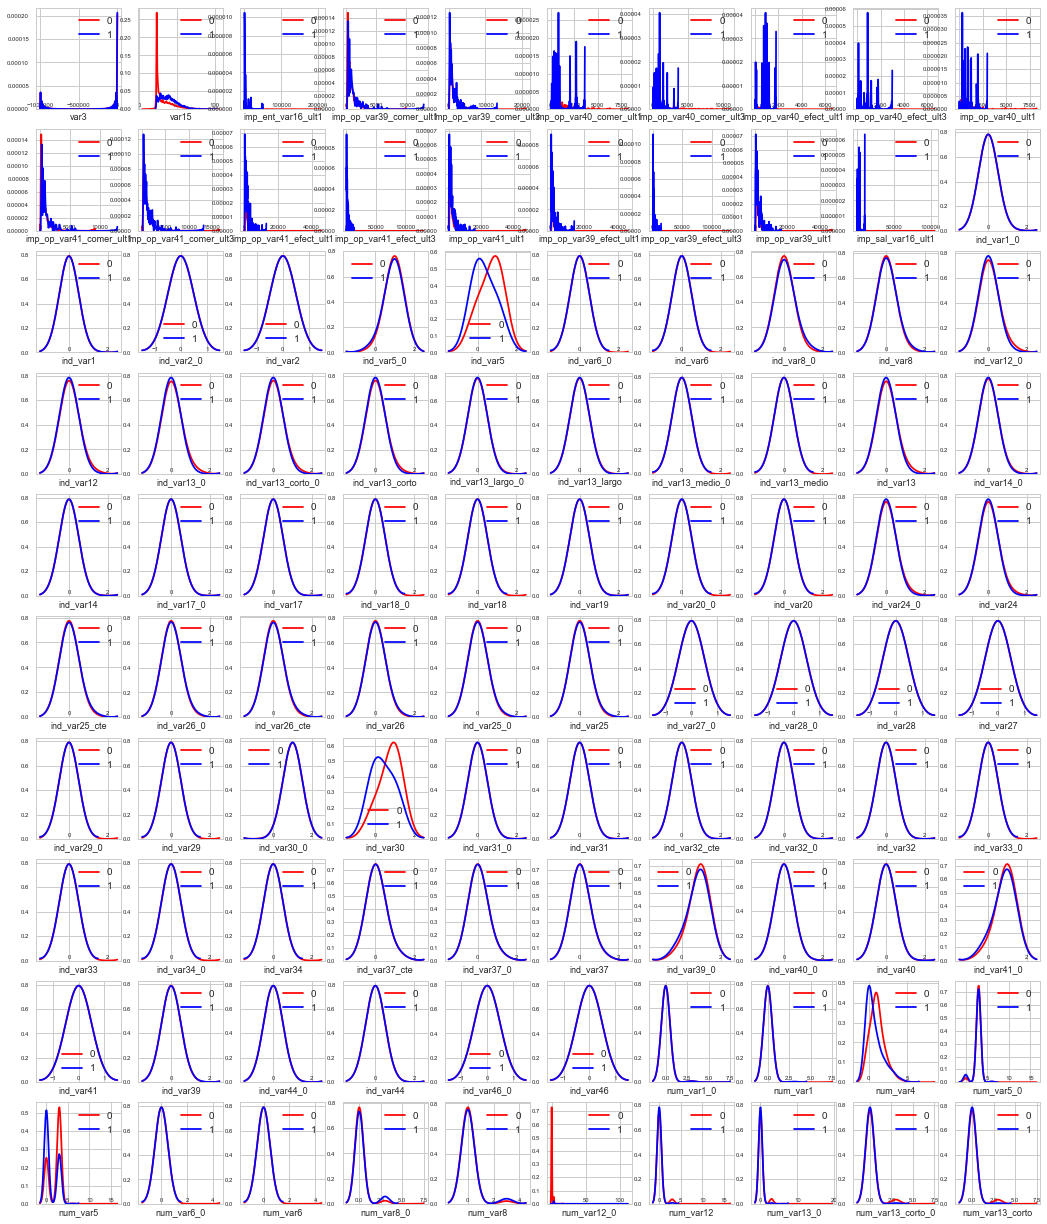

In [11]:
# Look at the first 100 features
plot_feature_distribution(data, features[:100])

Many features look redundant. These duplicated features can be removed.

In [12]:
# Remove constant features (std = 0)
remove = []
for col in data.columns:
    if data[col].std() == 0:
        remove.append(col)
        
data.drop(remove, axis=1, inplace=True)

In [13]:
data.shape

(76020, 337)

In [14]:
# Remove duplicated features
remove = []
cols = data.columns
for i in range(len(cols)-1):
    v = data[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v, data[cols[j]].values):
            remove.append(cols[j])

data.drop(remove, axis=1, inplace=True)

In [15]:
data.shape

(76020, 308)

In [16]:
# Remove strongly correlated features
redundant_features = [1] # initialise the list
while len(redundant_features) > 0:
    features = list(data.columns)
    features.remove('ID')
    features.remove('TARGET')
    correlations = data[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
    correlations = correlations[correlations['level_0'] != correlations['level_1']]
    correlations = correlations.dropna() #Remove entries involving zero variance in one of the 2 variables
    correlations = correlations[correlations.index % 2 == 0].reset_index() #Select one from 2 symmetric pairs
    redundant_features = correlations.loc[correlations[0]>0.9, 'level_1'].unique()
    data = data.drop(labels=redundant_features, axis=1)

In [17]:
data.shape

(76020, 156)

### Modelling

In [18]:
X = StandardScaler().fit_transform(data[features]) # Normalise features
y = data['TARGET']

# Reduce features dimensions using PCA
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)

print(X.shape, X_pca.shape)

(76020, 154) (76020, 100)


In [19]:
# Select best features with ExtraTreesClassifier to further reduce features dimensions
etclf = ExtraTreesClassifier()
selector = etclf.fit(X_pca, y)

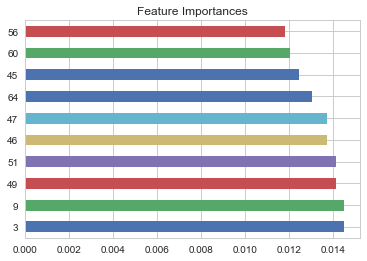

In [20]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(etclf.feature_importances_)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances')
plt.show()

In [21]:
fs = SelectFromModel(selector, prefit=True)
X_final = fs.transform(X_pca)

In [22]:
X_final.shape

(76020, 40)

In [23]:
# Train different models and select the best one
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.1, random_state=0)

clfs = {'Log':[LogisticRegression], 'Ridge':[RidgeClassifier],
        'RF':[RandomForestClassifier], 'GB':[GradientBoostingClassifier]}

for key, clf in clfs.items():
    score = cross_val_score(clf[0](), X_train, y_train, cv=2, scoring='roc_auc').mean()
    clf.append(score)

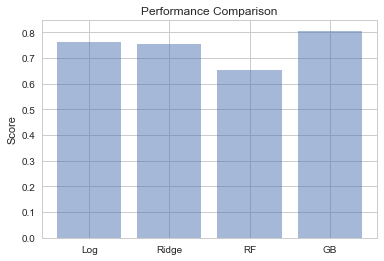

[0.7621471245820106, 0.7526941893942407, 0.6543571103139747, 0.8062388494013846]


In [24]:
# Plot scores for each classifier
x_pos = np.arange(len(clfs))
scores = []
clfs_labels = []
for key, clf in clfs.items():
    scores.append(clf[1])
    clfs_labels.append(key)

plt.bar(x_pos, scores, align='center', alpha=0.5)
plt.xticks(x_pos, clfs_labels)
plt.ylabel('Score')
plt.title('Performance Comparison')
 
plt.show()
print(scores)

Hence, GradientBoostingClassifier is the best one.

In [25]:
# Analyse the best model's performance on unseen data
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_predict_proba = clf.predict_proba(X_test)
score = roc_auc_score(y_test, y_predict_proba[:, 1])
score

0.8185263265742011

The model performs very well on unseen data too.